In [1]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import easyocr

from model.networks import Generator

plt.rcParams['figure.facecolor'] = 'white'

## Generate mask for the images

In [2]:
def get_image_shape(image_path):
    try:
        # Open the image using Pillow
        image = Image.open(image_path)

        # Get the width and height of the image
        width, height = image.size

        # Close the image file
        image.close()

        # Return the shape as a tuple (width, height)
        return (width, height)
    except Exception as e:
        print(f"Error loading the image: {str(e)}")
        return None
        
def create_mask_with_bounding_boxes(original_image, result):
    # Open the original image using Pillow
    # original_image = Image.open(image_path)

    # Create a blank black mask image with the same size as the original image
    mask = Image.new("L", original_image.size, 0)

    # Create a drawing object to draw white boxes on the mask
    draw = ImageDraw.Draw(mask)

    for box, _, _ in result:
        # Convert bounding box coordinates to integer
        box = [tuple(map(int, point)) for point in box]

        # Draw a white rectangle on the mask using the bounding box
        draw.polygon(box, outline=255, fill=255)

    return mask

In [3]:
# define images dir and destinatio dir for masks images
img_dir = "../data/img/"
img_masks_dir = "../data/masks/"

In [ ]:
# initiate ocr reader
reader = easyocr.Reader(['en'])

for filename in tqdm(os.listdir(img_dir)):
    image = Image.open(img_dir + filename)

    # generate image mask
    ocr_result = reader.readtext(np.array(image))
    image_mask = create_mask_with_bounding_boxes(image, ocr_result)

    # save image mask
    image_mask.save(f"{img_masks_dir}masked_{filename}","PNG")

## Load generator model


In [4]:
use_cuda_if_available = False
device = torch.device('cuda' if torch.cuda.is_available() 
                             and use_cuda_if_available else 'cpu')

model_path = 'pretrained/states_pt_places2.pth' # if you are using the other checkpoint, change the path accordingly

generator = Generator(checkpoint=model_path, return_flow=True, device = device).to(device)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


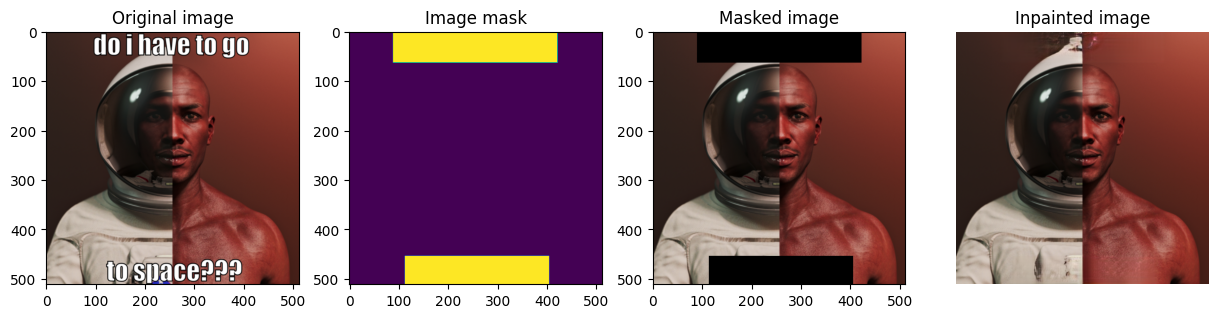

In [5]:
# single prediction

# extract the bounding boxes of text using OCR
image_path = f"{img_dir}01285.png"
reader = easyocr.Reader(['en'])
result = reader.readtext(image_path)

# create a mask for the image with conversion to three RGB channels
image_pil = Image.open(image_path).convert('RGB')
mask_pil = create_mask_with_bounding_boxes(image_pil, result)

# convert the PIL image to torch tensors
image = T.ToTensor()(image_pil).to(device)
mask = T.ToTensor()(mask_pil).to(device)


# apply the mask to the image
mask_tensor = (mask[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image*(1-mask_tensor)).permute(1, 2, 0).cpu()


# generate inpainted image
inpainted_image = generator.infer(image, mask, return_vals=['inpainted'])


# visualize the results
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
ax1.imshow(image_pil)
ax1.set_title('Original image')
ax2.imshow(mask_pil)
ax2.set_title('Image mask')
ax3.imshow(image_masked)
ax3.set_title('Masked image')
ax4.imshow(inpainted_image) 
ax4.set_title('Inpainted image')
plt.axis('off')
plt.show()

## Generate inpainted images

In [6]:
img_dir = '../data/img/'
img_masks_dir = f"../data/masks/"
inpainted_img_dir = '../data/inpainted_img/'

for filename in tqdm(os.listdir(img_dir)):
    # open the image with conversion to three channels RGB and the corresponding image mask
    image_pil = Image.open(img_dir + filename).convert('RGB')
    mask_pil = Image.open(f"{img_masks_dir}masked_{filename}")

    # convert the image from PIL format to torch tensor
    image = T.ToTensor()(image_pil).to(device)
    mask = T.ToTensor()(mask_pil).to(device)

    # generate the inpainted image
    inpainted_image = generator.infer(image, mask, return_vals=['inpainted'])

    # convert the image from np.array format to PIL
    inpainted_image = Image.fromarray(inpainted_image)
    
    # save the inpainted image
    inpainted_image.save(f"{inpainted_img_dir}{filename}","PNG")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [27:04<00:00, 16.25s/it] 
